# Adaptive Nonlinear Vector Autoregression: Robust Forecasting for Noisy Chaotic Time Series
## Author
- **Name**: Azimov Sherkhon Azizkhon Ugli
- **Email**: sherxonazimov94@pusan.ac.kr
- **GitHub**: @AzimovSherkhon

Method: **Adaptive Nonlinear Vector Autoregression** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_dtype(torch.float32)

In [2]:
# ----------------------------------------
# Device Info
# ----------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

Device in use: cuda
CUDA available: True
CUDA device: 0 - NVIDIA GeForce RTX 3060


In [3]:
# ----------------------------------------
# Reproducibility: Set Random Seeds
# ----------------------------------------
seed = 2025
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Enforce deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

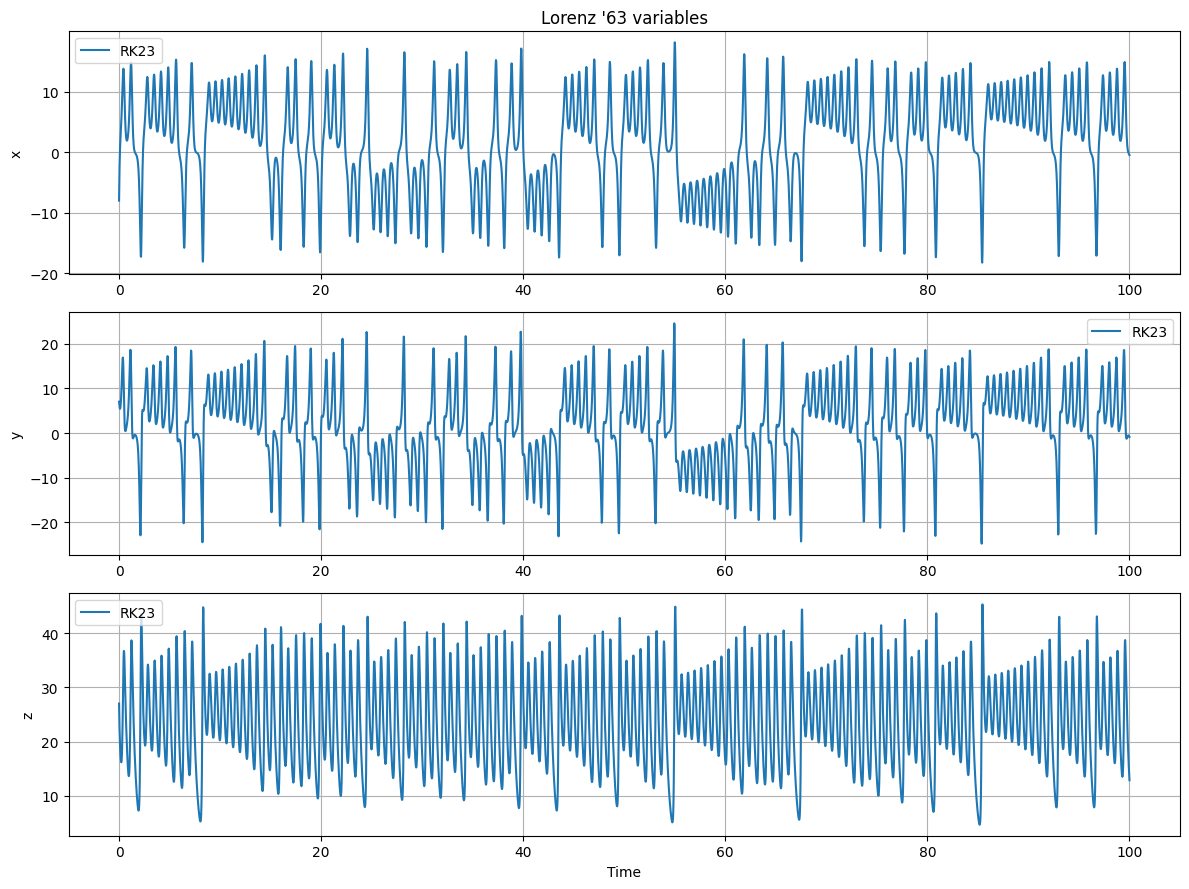

In [4]:
# ---------------------------
# Configuration 
# ---------------------------
dt = 0.025
maxtime = 100

maxtime_pts = int(maxtime / dt)  # 400 steps of 0.25
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)  # 401 time points

# ---------------------------
# Lorenz '63 System
# ---------------------------
lorenz_rk23 = np.load("ground_truth.npy")
Lorenz63data = lorenz_rk23.T

# ---------------------------
# Visualization
# ---------------------------
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_rk23[i], label='RK23', color='C0')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables")
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# ----------------------------------------
# Add Gaussian Noise
# ----------------------------------------
def add_relative_gaussian_noise(X_clean, noise_scale, random_seed):
    signal_std = np.std(X_clean, axis=0)
    noise = np.random.normal(loc=0.0, scale=noise_scale * signal_std, size=X_clean.shape)
    return X_clean + noise

# Use RK45 solution from earlier, transpose to shape (T, d)
Lorenz63data = lorenz_rk23.T
print("Lorenz63data shape:", Lorenz63data.shape)

# Generate noisy data
X_noisy = add_relative_gaussian_noise(Lorenz63data, noise_scale=0.10, random_seed=seed) # 10%


# Convert to PyTorch tensors
X = torch.tensor(X_noisy, dtype=torch.float32)
X_true = torch.tensor(Lorenz63data, dtype=torch.float32)

Lorenz63data shape: (4001, 3)


In [6]:
# ---------------------------
# Dataset Splitting
# ---------------------------
T_total = X.shape[0]
warmup_len = 200
train_len = 1600
test_len = 200

X_warmup = X[:warmup_len].to(device)
X_train = X[warmup_len:warmup_len + train_len].to(device)
X_test = X[warmup_len + train_len:warmup_len + train_len + test_len].to(device)
X_test_true = X_true[warmup_len + train_len:warmup_len + train_len + test_len].to(device)

# Shape logs
print("X_warmup shape:", X_warmup.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_warmup shape: torch.Size([200, 3])
X_train shape: torch.Size([1600, 3])
X_test shape: torch.Size([200, 3])


In [7]:
# ----------------------------------------
# Configuration Parameters of Adaptive NVAR
# ----------------------------------------
d = 3                      # Dimension of the Lorenz system (x, y, z)
k = 30                     # Number of time delays
dk = d * k                 # Dimension of linear input vector
m = int((dk * (dk + 1)) / 2)  # Output size for MLP (or use smaller (dk * (dk + 1)) / n)

print("MLP output size = Dimension of nonlinear feature vector:", m)

MLP output size = Dimension of nonlinear feature vector: 4095


In [8]:
# ---------------------------
# MLP Feature Map Definition
# ---------------------------
class FeatureMLP(nn.Module):
    """
    A multi-layer perceptron for nonlinear feature expansion.
    """
    def __init__(self, input_dim=dk, hidden_dim=2000, output_dim=m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(0.10),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class AdaptiveNVARModel(nn.Module):
    """
    Combines linear and nonlinear features using an MLP and a linear readout layer.
    """
    def __init__(self, dk, m, d):
        super().__init__()
        self.mlp = FeatureMLP(input_dim=dk, output_dim=m)
        self.readout = nn.Linear(dk + m, d, bias=False)

    def forward(self, H_lin):
        H_nn = self.mlp(H_lin)                     # [n, m]
        H_total = torch.cat([H_lin, H_nn], dim=1)  # [n, dk + m]
        return self.readout(H_total)               # [n, d]

# ---------------------------
# Delay Embedding Constructor
# ---------------------------
def construct_H_lin(X, k):
    T = X.shape[0]
    return torch.cat([X[i:T - k + i] for i in range(k)], dim=1)

# ---------------------------
# Joint Training Procedure
# ---------------------------
# ---------------------------
# Training Loop
# ---------------------------
def train_joint_model_with_lbfgs(X, k, m, num_epochs_adam=2000, num_epochs_lbfgs=5000,
                                 save_path="best_joint_model_10percent_noise.pth",  patience=50, tolerance=1e-10):
    X = X.to(device)
    H_lin = construct_H_lin(X, k)                 # [n, dk]
    Y = X[k:] - X[k - 1:-1]                       # [n, d]
    n, dk = H_lin.shape
    d = Y.shape[1]

    model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)

    # --- Phase 1: Train with Adam
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam, weight_decay=weight_decay)
    optimizer = torch.optim.Adam(model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
    foreach=None,
    capturable=False,
    differentiable=False,
    fused=None
     )
    adam_losses = []
    for epoch in range(num_epochs_adam):
        model.train()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adam_losses.append(loss.item())
        if epoch % 1000 == 0 or epoch == num_epochs_adam - 1:
            print(f"[Adam] Epoch {epoch:3d} | Loss: {loss.item():.4e}")

    # Save Adam-trained model state before L-BFGS
    torch.save(model.state_dict(), save_path)

    # --- Phase 2: Fine-tune with L-BFGS
    model.load_state_dict(torch.load(save_path))
    optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,
    max_eval=None,
    tolerance_grad=1e-6,
    tolerance_change=1e-11,
    history_size=20,
    line_search_fn=None
     )
    lbfgs_losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    def closure():
        optimizer.zero_grad()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)
        loss.backward()
        return loss

    for epoch in range(num_epochs_lbfgs):
        model.train()
        loss = optimizer.step(closure)
        current_loss = loss.item()
        lbfgs_losses.append(current_loss)
        if epoch % 100 == 0 or epoch == num_epochs_lbfgs - 1:
            print(f"[L-BFGS] Epoch {epoch:3d} | Loss: {current_loss:.4e}")

        # Early stopping logic
        if best_loss - current_loss > tolerance:
            best_loss = current_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Final model saved after L-BFGS fine-tuning.")
    return model, adam_losses, lbfgs_losses


In [9]:
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import display  
# ---------------------------
# Train and Time the Process
# ---------------------------
start_time = time.time()

# Train the model 
model, adam_losses, lbfgs_losses = train_joint_model_with_lbfgs(X_train, k=k, m=m)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total training time: {elapsed_time:.2f} seconds")



[Adam] Epoch   0 | Loss: 5.8166e+00
[Adam] Epoch 1000 | Loss: 5.3024e-01
[Adam] Epoch 1999 | Loss: 3.3807e-01
[L-BFGS] Epoch   0 | Loss: 3.2625e-01
Early stopping triggered at epoch 96
Final model saved after L-BFGS fine-tuning.
Total training time: 102.74 seconds


In [10]:
# ---------------------------
# Load the Best Model for Evaluation
# ---------------------------
model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)
model.load_state_dict(torch.load("best_joint_model_10percent_noise.pth"))
model.eval()

AdaptiveNVARModel(
  (mlp): FeatureMLP(
    (net): Sequential(
      (0): Linear(in_features=90, out_features=2000, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=2000, out_features=4095, bias=True)
    )
  )
  (readout): Linear(in_features=4185, out_features=3, bias=False)
)

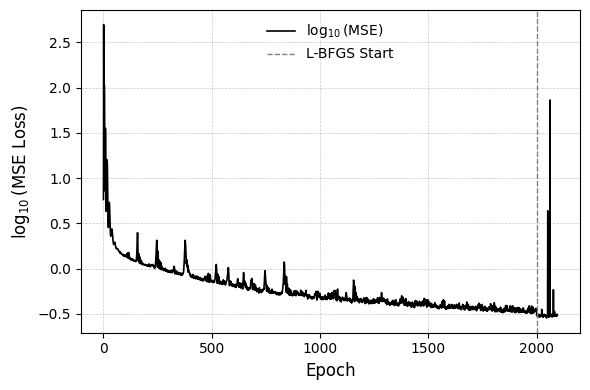

In [11]:
# ---------------------------
# Plot Training Loss (log scale)
# ---------------------------
total_losses = adam_losses + lbfgs_losses
total_epochs = np.arange(len(total_losses))
split_point = len(adam_losses)

log_losses = np.log10(np.array(total_losses))

plt.figure(figsize=(6, 4))
plt.plot(total_epochs, log_losses, color='black', linewidth=1.2, label=r'$\log_{10}(\mathrm{MSE})$')
plt.axvline(split_point, color='gray', linestyle='--', linewidth=1, label='L-BFGS Start')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel(r'$\log_{10}(\mathrm{MSE\ Loss})$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save high-resolution plot
plt.savefig("training_loss_log_curve_10percent_noise.png", dpi=300, bbox_inches='tight')
plt.show()

Training MSE: 1.1512e-01


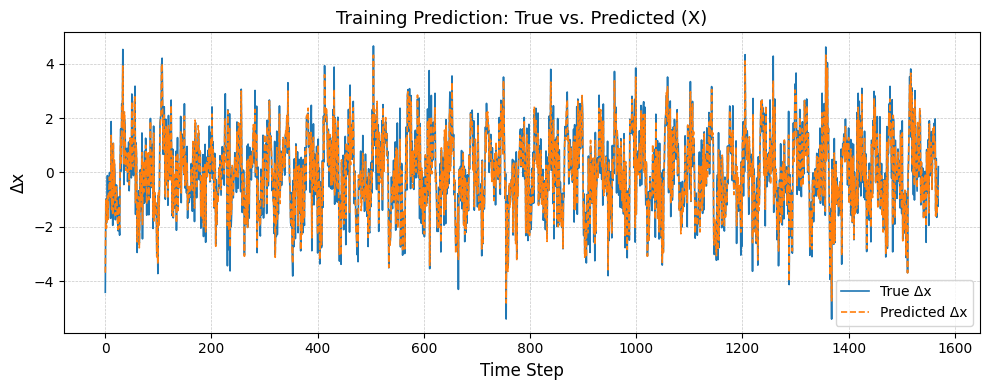

In [12]:
# ---------------------------
# Evaluate on Training Data
# ---------------------------
# Construct delay-embedded input for training
H_lin = construct_H_lin(X_train, k)

# Forward pass (inference mode)
with torch.no_grad():
    Y_hat_train = model(H_lin)  # Predicted state difference: shape [n, d]

# Ground truth target: finite difference in state
Y_train = X_train[k:] - X_train[k - 1:-1]

# Compute MSE loss
mse_train = F.mse_loss(Y_hat_train, Y_train)
print(f"Training MSE: {mse_train.item():.4e}")

# ---------------------------
# Plot: True vs Predicted (first component)
# ---------------------------
plt.figure(figsize=(10, 4))
plt.plot(Y_train[:, 0].cpu(), label="True Δx", linewidth=1.2)
plt.plot(Y_hat_train[:, 0].cpu(), label="Predicted Δx", linewidth=1.2, linestyle="--")

plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Δx", fontsize=12)
plt.title("Training Prediction: True vs. Predicted (X)", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


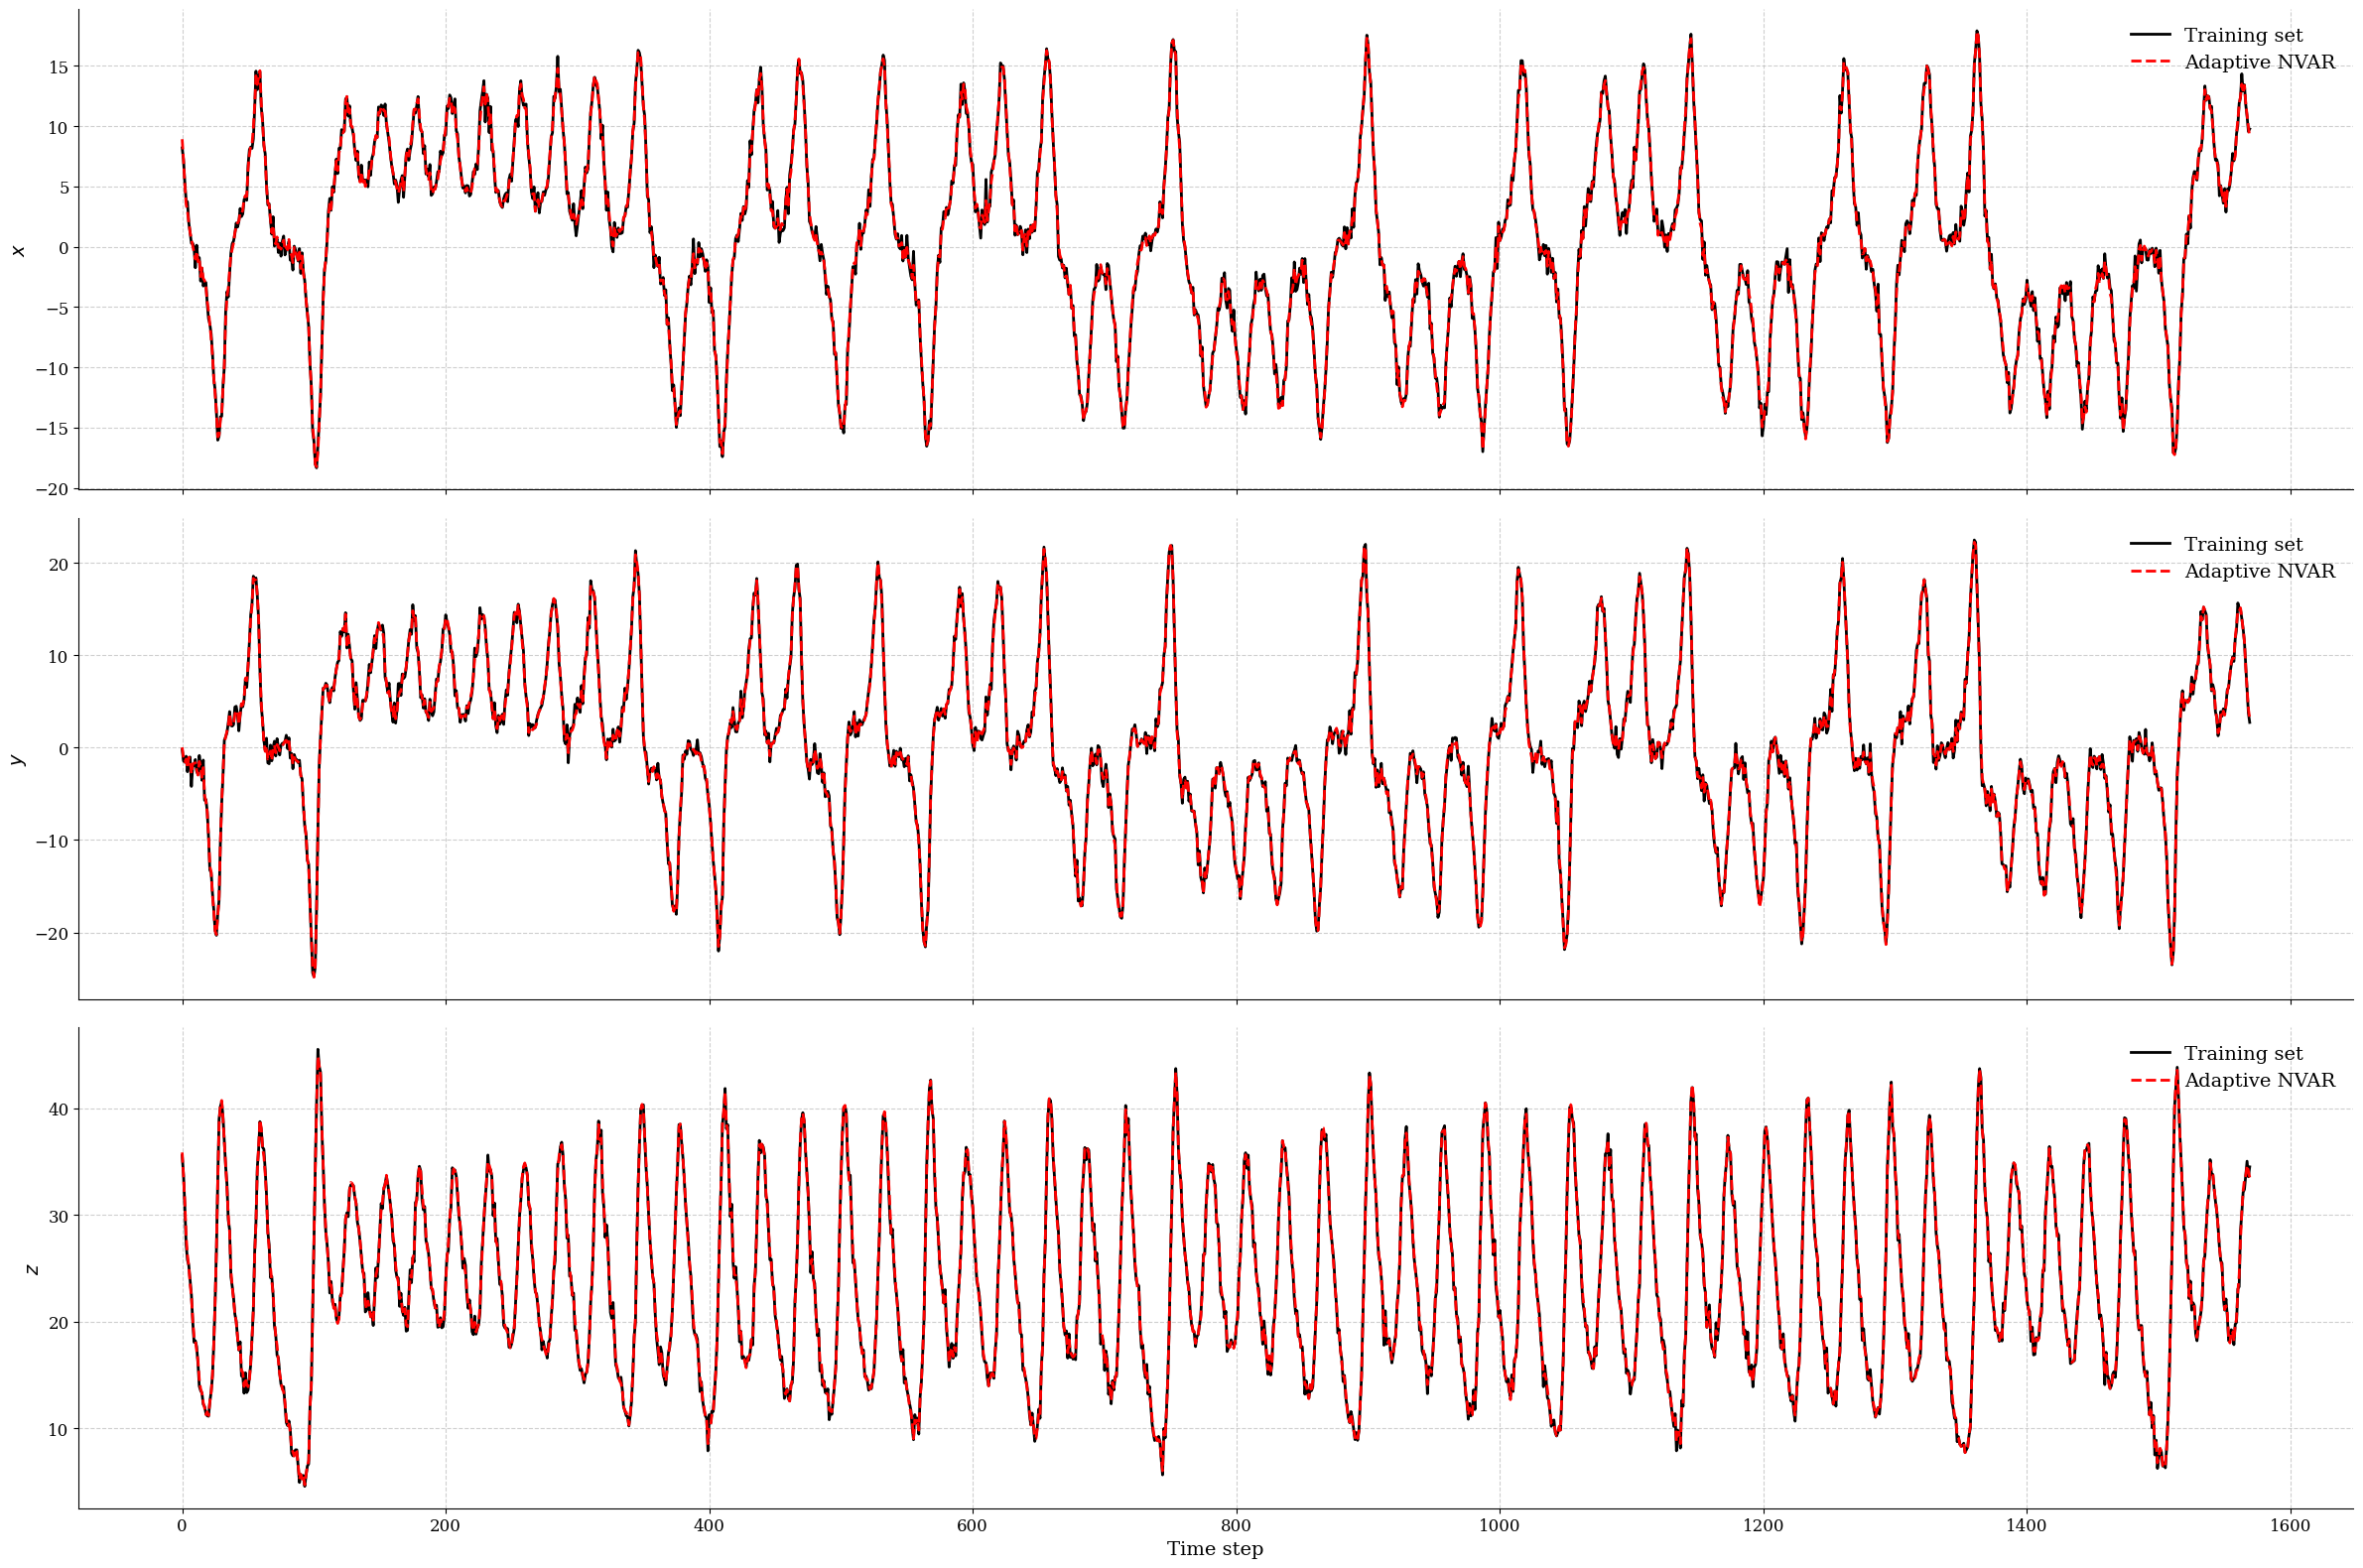

In [13]:
# ---------------------------
# Reconstruct Predicted States: x_{t+1} ≈ x_t + Δx
# ---------------------------
x_t = X_train[k - 1:-1]                # Reference states x_t
Y_hat = x_t + Y_hat_train             # Reconstructed x_{t+1}

# Convert tensors to NumPy for plotting
Y_hat_np = Y_hat.cpu().numpy()
X_np = X_train[k:].cpu().numpy()

# Time index for plotting
time = np.arange(Y_hat_np.shape[0])
variable_names = ['x', 'y', 'z']

# ---------------------------
# Plot: Training data vs. Predicted State Trajectories
# ---------------------------
mpl.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2
})

variable_names = ['x', 'y', 'z']
colors = ['black', 'red']

# Plot each variable
fig, axs = plt.subplots(3, 1, figsize=(24, 16), sharex=True)  

for i in range(3):
    axs[i].plot(time, X_np[:, i], label='Training set', color=colors[0])
    axs[i].plot(time, Y_hat_np[:, i], label='Adaptive NVAR', linestyle='--', color=colors[1])
    axs[i].set_ylabel(f"${variable_names[i]}$")
    axs[i].legend(loc='upper right', frameon=False)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

axs[-1].set_xlabel("Time step")

plt.tight_layout()
fig.savefig("adaptive_nvar_training_predictions_10percent.png", dpi=600, bbox_inches='tight')
plt.show()

In [14]:
# -----------------------------
# Load Next Generation Reservior Computing=NVAR test results
# -----------------------------
Xtestngrc = np.load("testngrc_10noise.npy")
Xtestngrc = Xtestngrc.T

In [15]:
# -----------------------------
# Auto-Regressive Prediction
# -----------------------------
X_init = X_train[-k:]                           # Last k states from training
x_t = [x.clone() for x in X_init.unbind(0)]     # Delay buffer: list of d-dim tensors
H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)     # Initial input: shape [1, dk]

predictions = []
num_steps = len(X_test)

for _ in range(num_steps):
    with torch.no_grad():
        delta_x = model(H_lin)                  # Predict Δx
    x_next = x_t[-1] + delta_x.squeeze(0)       # x_{t+1} = x_t + Δx
    predictions.append(x_next)

    x_t = x_t[1:] + [x_next]                    # Update buffer
    H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)
# Convert predictions to numpy for easy plotting
predictions_np = torch.stack(predictions).detach().cpu().numpy()

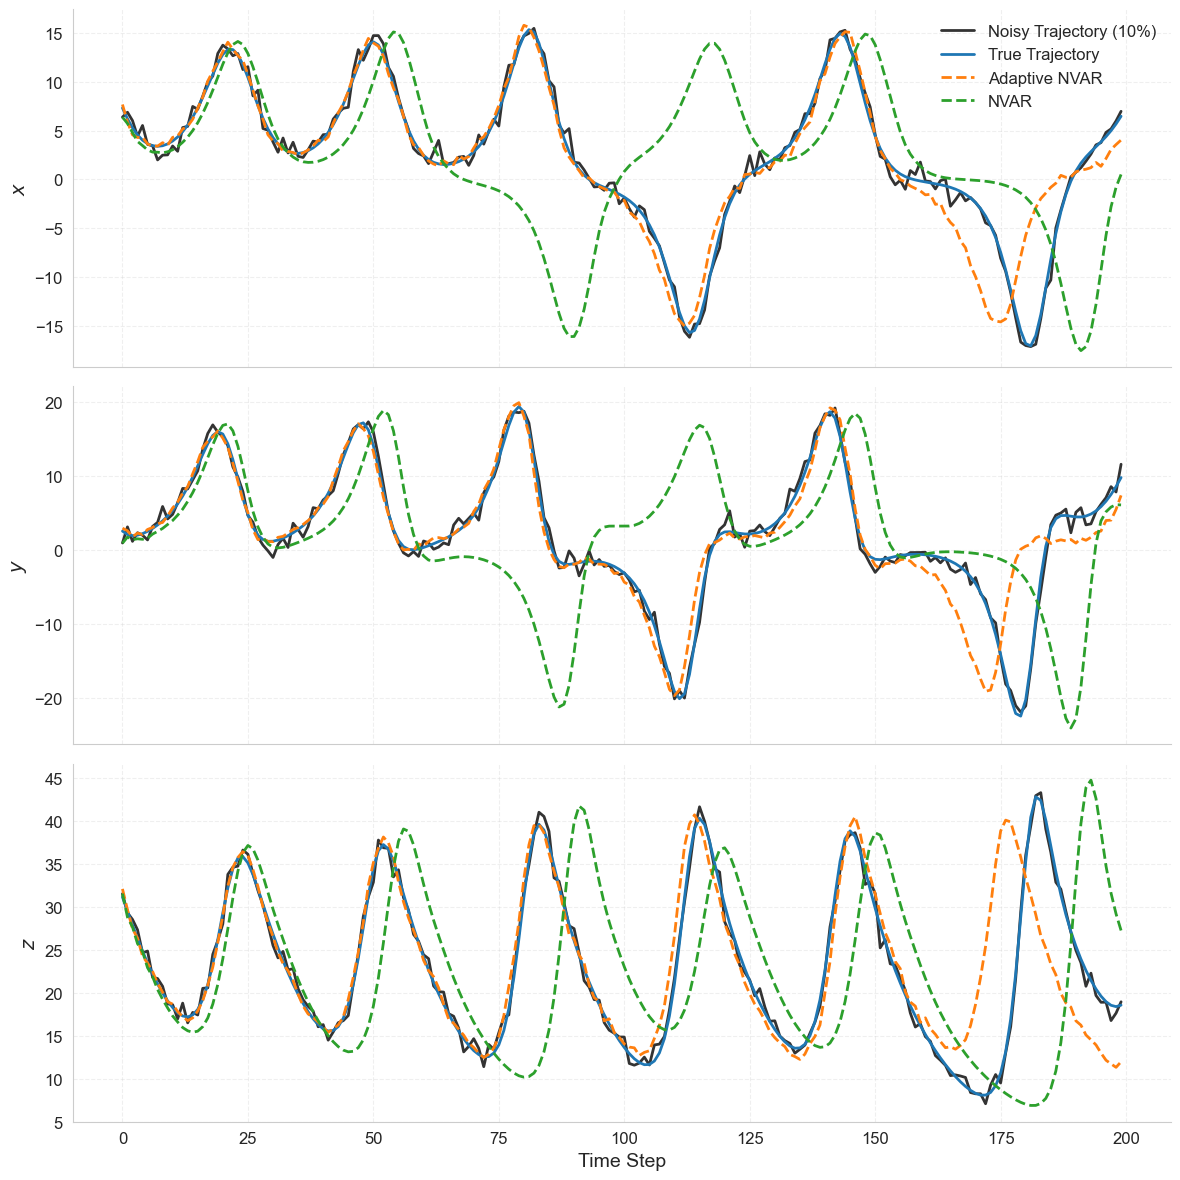

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2
})

sns.set_style("whitegrid")

# Time axis setup
num_steps = len(X_test)
time_steps = range(num_steps)
variable_names = ['x', 'y', 'z']

# Colorblind-friendly color palette
colors = {
    'noisy': '#333333',         # dark gray
    'true': '#1f77b4',          # blue
    'adaptive': '#ff7f0e',      # orange
    'nvar': '#2ca02c'           # green
}

# Create figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i in range(3):
    axs[i].plot(time_steps, X_test[:, i].detach().cpu().numpy(), label='Noisy Trajectory (10%)', color=colors['noisy'])
    axs[i].plot(time_steps, X_test_true[:, i].detach().cpu().numpy(), label='True Trajectory', color=colors['true'])
    axs[i].plot(time_steps, predictions_np[:, i], '--', label='Adaptive NVAR', color=colors['adaptive'])
    axs[i].plot(time_steps, Xtestngrc[:, i], '--', label='NVAR', color=colors['nvar'])

    axs[i].set_ylabel(f"${variable_names[i]}$")
    axs[i].grid(True, linestyle='--', alpha=0.3)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


axs[0].legend(loc='upper right', frameon=False)
axs[-1].set_xlabel("Time Step")
plt.tight_layout()
fig.savefig("adaptive_nvar_test_noise10.png", format='png', dpi=600, bbox_inches='tight')  
plt.show()
